In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import collections

In [2]:
n_states = 2

In [3]:
def onehot(idx, N):
    return np.eye(N)[idx]

def generate_Mpi(n_states, n_actions, ps):
    """
    A policy is represented by a block diagonal |S| x |S||A| matrix M.
    
    Args:
        n_states (int): the number of states
        n-actions (int): the number of actions
        ps (array[n_states, n_actions]): the probabilities of taking action a in state s.
        
    Returns:
        (array[n_states, n_states x n_actions])
    """
    # ps = len n_states. ps[0] = len n_actions
    M_pi = np.zeros((n_states, n_states * n_actions))
    M_pi[tuple(zip(*[(i, i*n_actions+j) for i in range(n_states) for j in range(n_actions) ]))] = ps.reshape(-1)
    return M_pi

def pi(M_pi, s, a):
    """
    Let state s be indexed by i and the action a be indexed by j.
    Then we have that M[i, i x |A| + j] = pi(a|s)
    """
    return M_pi[s, s*n_actions+a]

In [4]:
n_states = 2
n_actions = 3
Mpi = generate_Mpi(n_states, n_actions, rnd.random((n_states, n_actions,)))
assert Mpi.shape == (n_states, n_states * n_actions)

In [5]:
Mpi.shape

(2, 6)

In [6]:
def normalise(x, axis):
    return x/np.sum(x, axis=axis, keepdims=True)

def exp_dist(x, lambda_=3.5):  # why 3.5!?
    return lambda_*np.exp(-lambda_*x)

def uniform_simplex(shape):
    # god damn. it's not as simple as I thought to generate uniform distributions on simplexs
    # https://cs.stackexchange.com/questions/3227/uniform-sampling-from-a-simplex
    # http://www.cs.cmu.edu/~nasmith/papers/smith+tromble.tr04.pdf
    return normalise(exp_dist(rnd.random(shape)),axis=1)

generate_rnd_policy = lambda n_states, n_actions: generate_Mpi(n_states, 
                                                               n_actions, 
                                                               uniform_simplex((n_states, n_actions)))

# and generating a grid isnt so easy either...
# TODO want to verify we have a normal dist

In [7]:
n_states = 4
n_actions = 2
Mpi = generate_rnd_policy(n_states, n_actions)
assert Mpi.shape == (n_states, n_states*n_actions)

ps = [pi(Mpi, i, j) for i in range(n_states) for j in range(n_actions)]
for p in ps:
    assert p != 0
    
    
# TODO need to check if they are normalised in the right way

In [8]:
def generate_rnd_problem(n_states, n_actions):
    P = rnd.random((n_states * n_actions, n_states))**2
    P = P/P.sum(axis=1, keepdims=True)
    r = rnd.random((n_states * n_actions, 1))
    return P, r

## Value functional

$$
\begin{align}
V(\pi) &= r_{\pi} + \gamma P_{\pi} V \\
&= (I − \gamma P_{\pi})^{−1}r_{\pi}
\end{align}
$$

In [9]:
def value_functional(P, r, M_pi, gamma):
    """
    V = f(pi)
      = (T-\gamma P_{\pi})^{-1}r_{\pi}
    """
    n = P.shape[-1]
    P_pi = np.dot(M_pi, P)
    r_pi = np.dot(M_pi, r)    
    return np.dot(np.linalg.inv(np.eye(n) - gamma*P_pi), r_pi)

P, r = generate_rnd_problem(n_states, n_actions)
V = value_functional(P, r, generate_rnd_policy(n_states, n_actions), 0.9)
print(V.shape)

(4, 1)


In [380]:
# TODO need to generalise to n-actions

# generalising to n-states requires higher dim visualisations (not easy.).
# instead I need to find metrics that make sense of them. 
# and then plot metrics of higher dim state spaces

def gen_grid_policies(n_states, n_actions, N=11):
     # will not generalise to n states / actions
    # works for 2 states, 2 actions
    x = np.linspace(0, 1, N)
    return [np.array([x[i],1-x[i],x[j],1-x[j]]) # will not generalise to n states
                  for i in range(N) 
                  for j in range(N)]

def gen_s_deterministic_policies(n_states, n_actions):
     # will not generalise to n states / actions
    # works for 2 states, 2 actions
    N = 11
    x = np.linspace(0, 1, N)
    return ([np.array([x[i],1-x[i], 0, 1]) for i in range(N)] + 
            [np.array([x[i],1-x[i], 1, 0]) for i in range(N)] +
            [np.array([0, 1, x[j],1-x[j]]) for j in range(N)] + 
            [np.array([1, 0, x[j],1-x[j]]) for j in range(N)])

def gen_deterministic_policies(n_states, n_actions):
     # will not generalise to n states / actions
    # works for 2 states, 2 actions
    return [np.hstack([onehot(i, n_actions), onehot(j, n_actions)])
                  for i in range(n_actions) 
                  for j in range(n_actions)]

def scatter_policies(pis, P, r, n_states, n_actions, c='b'):
    Vs = np.hstack([value_functional(P, r, generate_Mpi(n_states, n_actions, pi), 0.9) 
                    for pi in pis])

    plt.scatter(Vs[0, :], Vs[1, :], c=c)
    
def fill_policies(pis, P, r, n_states, n_actions, c='b'):
    vert_Vs = np.hstack([value_functional(P, r, generate_Mpi(n_states, n_actions, pi), 0.9) 
                for pi in s_det_pis])
    plt.fill(vert_Vs[0], vert_Vs[1])

def plot_rnd_policies(P, r, n_states, n_actions):
    Vs = np.hstack([value_functional(P, r, generate_rnd_policy(n_states, n_actions), 0.9) for _ in range(100000)])
    plt.scatter(Vs[0, :], Vs[1, :], s=1, alpha=0.1)
    
def plot_density(P, r, n_states, n_actions):
    # can we calculate this analytically? p(V) = inv(abs(1/det(dVdx))) p(x)
    Vs = np.hstack([value_functional(P, r, generate_rnd_policy(n_states, n_actions), 0.9) for _ in range(100000)])
    _ = plt.hist2d(Vs[0, :], Vs[1, :], (100, 100), cmap=plt.cm.jet)

In [381]:
# Ok. let's reproduce the figures from the paper.

Section3Figures = collections.namedtuple('Section3Figures', ['figa', 'figb', 'figc', 'figd'])
section3figures = Section3Figures(
    (2, np.array([[0.01, 0.99], [0.92, 0.08], [0.08, 0.92], [0.70, 0.30]]),
     np.array([[0.06], [0.38], [-0.13], [0.64]])),
    (2, np.array([[0.96, 0.04], [0.19, 0.81], [0.43, 0.57], [0.72, 0.28]]),
    np.array([[0.88], [-0.02], [-0.98], [0.42]])),
    (3, np.array([[0.52, 0.48], [0.5, 0.5], [0.99, 0.01], [0.85, 0.15], [0.11, 0.89], [0.1, 0.9]]),
    np.array([[-0.93], [-0.49], [0.63], [0.78], [0.14], [0.41]])),
    (2, np.array([[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]]),
    np.array([[-0.45], [-0.1], [0.5], [0.5]]))
)

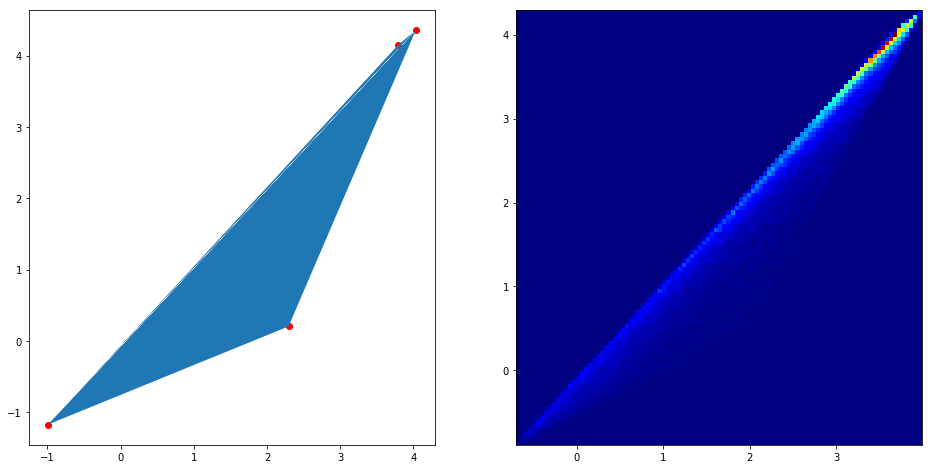

In [382]:
n_states = 2
n_actions, P, r = section3figures.figa

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
det_pis = gen_deterministic_policies(n_states, n_actions)
scatter_policies(det_pis, P, r, n_states, n_actions, c='r')
s_det_pis = gen_s_deterministic_policies(n_states, n_actions)
fill_policies(det_pis, P, r, n_states, n_actions, c='b')
plt.subplot(1,2,2)
plot_density(P, r, n_states, n_actions)


# so this seems like an easier problem than the others?
# any policy we sample is likely to be near the optima?

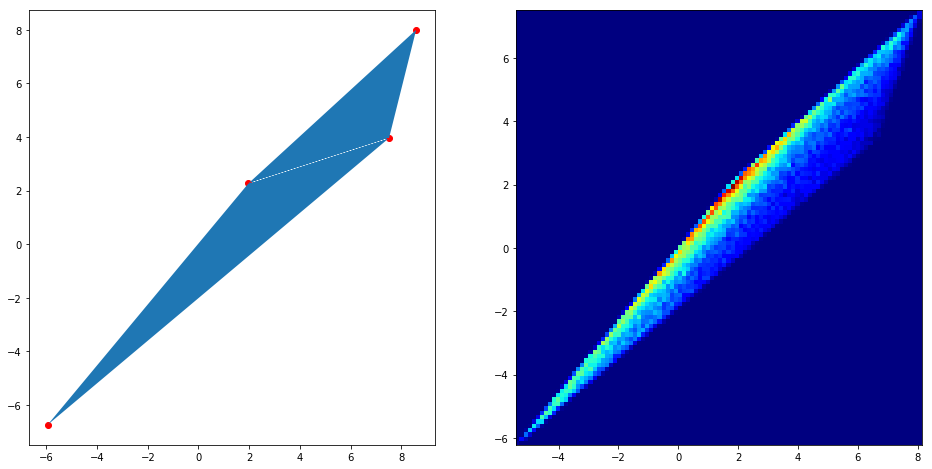

In [366]:
n_actions, P, r = section3figures.figb
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
det_pis = gen_deterministic_policies(n_states, n_actions)
scatter_policies(det_pis, P, r, n_states, n_actions, c='r')
s_det_pis = gen_s_deterministic_policies(n_states, n_actions)
fill_policies(det_pis, P, r, n_states, n_actions, c='b')
plt.subplot(1,2,2)
plot_density(P, r, n_states, n_actions)

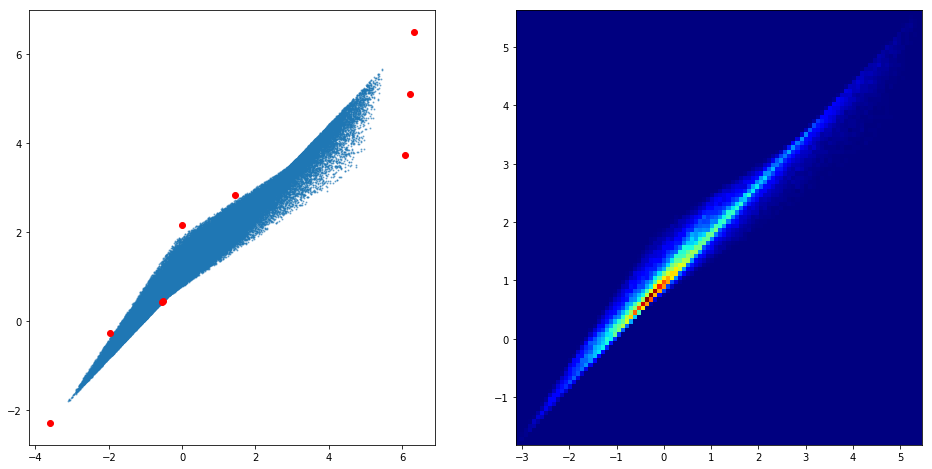

In [28]:
n_actions, P, r = section3figures.figc
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plot_rnd_policies(P, r, n_states, n_actions)
plot_s_deterministic_policies(P, r, n_states, n_actions)
plt.subplot(1,2,2)
plot_density(P, r, n_states, n_actions)

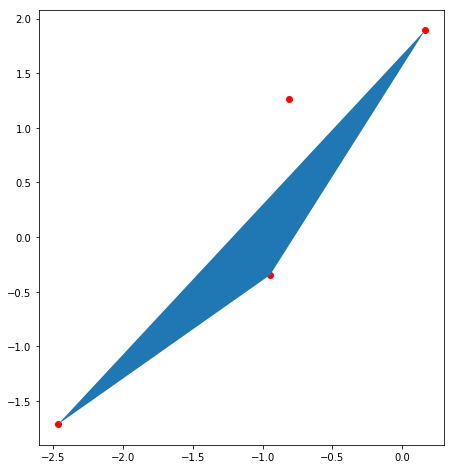

In [379]:
n_actions, P, r = section3figures.figd
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
det_pis = gen_deterministic_policies(n_states, n_actions)
scatter_policies(det_pis, P, r, n_states, n_actions, c='r')
s_det_pis = gen_s_deterministic_policies(n_states, n_actions)
fill_policies(det_pis, P, r, n_states, n_actions, c='b')
plt.subplot(1,2,2)
plot_density(P, r, n_states, n_actions)

# BUG ahh. fill doesnt work. hasnt plotted correctly

In [250]:
Vs = np.hstack([value_functional(P, r, generate_rnd_policy(n_states, n_actions), 0.9) for _ in range(100000)])

In [251]:
density, _, _ = np.histogram2d(Vs[1], Vs[0], bins=(100,100))

In [253]:
# for all values in the polytope (how do I get them...)
# calculate the entropy
entropy(density)

array([[16.,  8.,  0., ...,  0.,  0.,  0.],
       [ 0., 37., 41., ...,  0.,  0.,  0.],
       [ 0.,  0., 44., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 25.,  0.,  0.],
       [ 0.,  0.,  0., ..., 14., 12.,  0.],
       [ 0.,  0.,  0., ...,  1.,  8.,  6.]])

In [118]:
def solve(update_fn, P, r, Mpi, discount, atol=1e-4, maxiters=10):
    """
    Generates the dynamics of update_fn .
    Initial condition = Mpi
    
    An ODE solver!?
    """
    converged = False
    pis = [Mpi]
    vs = [value_functional(P, r, Mpi, 0.9)]
    count = 0
    while not converged:
        Mpi = update_fn(P, r, Mpi, discount)
        V = value_functional(P, r, Mpi, 0.9)
        
        if np.isclose(vs[-1] - V, np.zeros(V.shape)).all():
            converged = True
        else:
            vs.append(V)
            pis.append(Mpi)
            
            
        count += 1
        if count > maxiters-2:
            break
        
    return pis, vs

In [273]:
def softmax(x, axis=1, temp=10.0):
    x *= temp
    return np.exp(x)/np.sum(np.exp(x), axis=1)

def greedy_solution(V, P):
    n_states = P.shape[-1]
    n_actions = P.shape[0]//P.shape[-1]
    EV = np.dot(P, V).reshape((n_states, n_actions))  # expected value of each action in each state
    return generate_Mpi(n_states, n_actions, np.clip(np.round(softmax(EV)),0, 1))

def policy_iteration_update(P, r, M_pi, gamma):
    V = value_functional(P, r, M_pi, gamma)
    return greedy_solution(V, P)

In [274]:
n_states= 2
n_actions, P, r = section3figures.figb
Mpi = generate_rnd_policy(n_states, n_actions)
V1 = value_functional(P, r, Mpi, 0.9)
print(Mpi)
Mpi = policy_iteration_update(P, r, Mpi, 0.9)
print(Mpi)
V2 = value_functional(P, r, Mpi, 0.9)

[[0.16809442 0.83190558 0.         0.        ]
 [0.         0.         0.70425572 0.29574428]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [275]:
pis, vs = solve(policy_iteration_update, P, r, generate_rnd_policy(n_states, n_actions), 0.9)
# ok. figa doesnt converge using this!?!? why?
# is GPI guaranteed to converge?

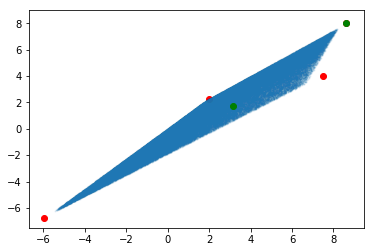

In [276]:
plot_s_deterministic_policies(P, r, n_states, n_actions)
plot_rnd_policies(P, r, n_states, n_actions)
plt.scatter(*[x for x in np.hstack(vs)], c='g')  # TODO want to use cmap to show convergence

In [281]:
def policy_iteration_partitions(n_states, n_actions, P, r):
    lens = []
    Vs = []
    for _ in range(10000):
        pi, vs = solve(policy_iteration_update, P, r, generate_rnd_policy(n_states, n_actions), 0.9)
        Vs.append(vs[0])
        lens.append(len(vs))
    return lens, Vs

def plot_partitions(Vs, lens):
    plt.scatter(*[x for x in np.hstack(Vs)], c=lens, s=1)
    plt.colorbar()

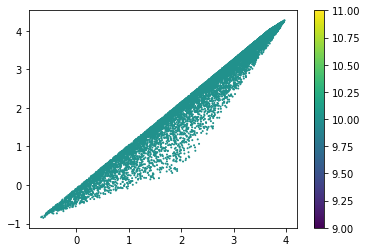

In [282]:
# BUG uhh. why doesnt GPI work on this?!
n_states= 2
n_actions, P, r = section3figures.figa
lens, Vs = policy_iteration_partitions(n_states, n_actions, P, r)
plot_partitions(Vs, lens)

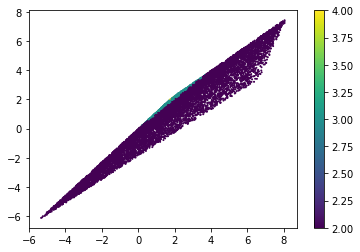

In [283]:
# QUESTION ok, what makes these initial policies harder to solve? why???
n_states= 2
n_actions, P, r = section3figures.figb
lens, Vs = policy_iteration_partitions(n_states, n_actions, P, r)
plot_partitions(Vs, lens)

In [284]:
n_states= 2
n_actions, P, r = section3figures.figc
lens, Vs = policy_iteration_partitions(n_states, n_actions, P, r)
plot_partitions(Vs, lens)

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

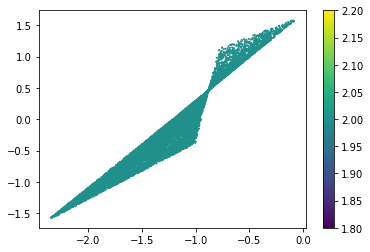

In [286]:
n_states= 2
n_actions, P, r = section3figures.figd
lens, Vs = policy_iteration_partitions(n_states, n_actions, P, r)
plot_partitions(Vs, lens)

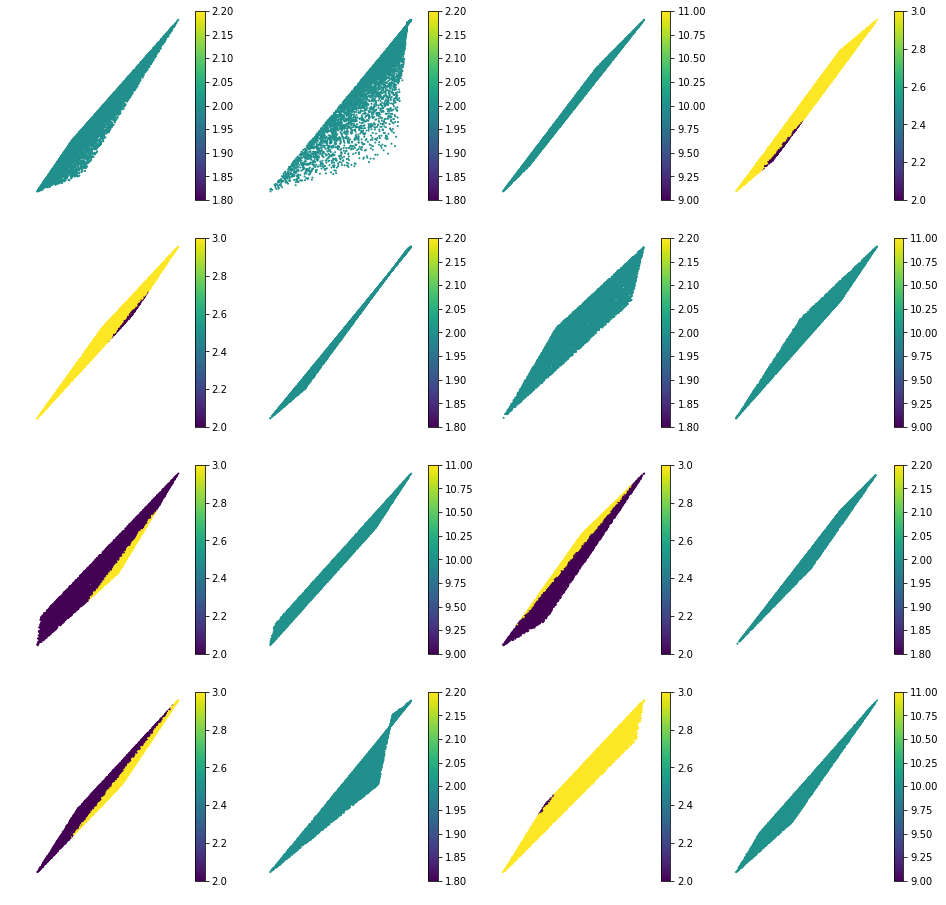

In [294]:
n_states = 2
n_actions = 2
plt.figure(figsize=(16,16))
n = 4
for i in range(n*n):
    P, r = generate_rnd_problem(n_states, n_actions)
    lens, Vs = policy_iteration_partitions(n_states, n_actions, P, r)
    plt.subplot(n,n,i+1)
    plot_partitions(Vs, lens)
    plt.axis('off')

In [101]:
# so with high probability we are going to sample a policy that can be easily updated to the optimal one.

### Policy gradients



In [208]:
def policy_gradient_update(P, r, M_pi, gamma):
    # ∇J(θ) = ∇log π(a | s) [r(s, a) + γE V (s')]
    V = value_functional(P, r, M_pi, gamma)
    EV = np.dot(P, V)
    
    dJ = np.log(M_pi) * (r.T - EV.T)
    dJ[dJ == -np.inf] = 0
    dJ[dJ == np.inf] = 0

    return M_pi + 0.001*dJ

In [211]:
M_pi = generate_rnd_policy(n_states, n_actions)
pis, vs = solve(policy_gradient_update, P, r, M_pi, 0.9, atol=1e-6, maxiters=300)
# BUG hmm, has a tendency to diverge!?
# ok, so which starting points tend to diverge?

/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


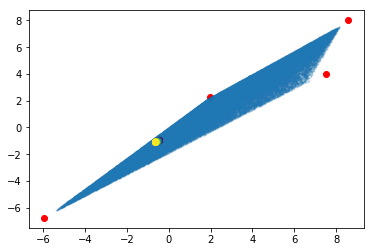

In [212]:
plot_s_deterministic_policies(P, r, n_states, n_actions)
plot_rnd_policies(P, r, n_states, n_actions)
plt.scatter(*[x for x in np.hstack(vs)], c=range(len(vs)))  # TODO want to use cmap to show convergence

In [175]:
vert_pis = gen_s_deterministic_policies(n_states, n_actions)
vs = np.hstack([value_functional(P, r, generate_Mpi(n_states, n_actions, pi), 0.9) for pi in vert_pis])
v_star = vs[:, np.argmax(np.sum(vs**2, axis=0))]

In [184]:
progress = []
suboptimality = []
for _ in range(1000):
    M_pi = generate_rnd_policy(n_states, n_actions)
    pis, vs = solve(policy_gradient_update, P, r, M_pi, 0.9, atol=1e-6, maxiters=300)
    progress.append(np.sum((vs[0] - vs[-1])**2))
    suboptimality.append(np.sum((v_star - vs[-1])**2))

/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


(array([660.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.68577529e+00, 5.81702173e+04, 1.16336749e+05, 1.74503280e+05,
        2.32669812e+05, 2.90836343e+05, 3.49002875e+05, 4.07169406e+05,
        4.65335938e+05, 5.23502469e+05, 5.81669001e+05]),
 <a list of 10 Patch objects>)

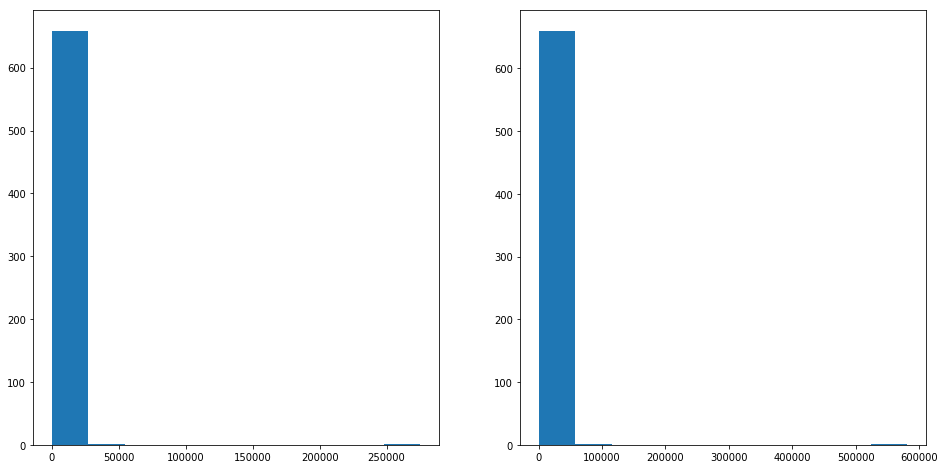

In [185]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(progress)

plt.subplot(1,2,2)
plt.hist(suboptimality)

In [219]:
# plot initial position/policy colored by suboptimality after training.
Vs = []
suboptimality = []
for _ in range(1000):
    M_pi = generate_rnd_policy(n_states, n_actions)
    pis, vs = solve(policy_gradient_update, P, r, M_pi, 0.9, atol=1e-6, maxiters=300)
    suboptimality.append(np.sum((v_star - vs[-1])**2))
    Vs.append(vs[0])

/local/scratch/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


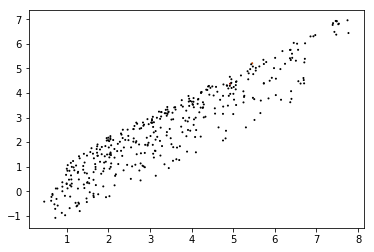

In [223]:
plt.scatter(*[x for x in np.hstack(Vs)], c=suboptimality, s=1)#, cmap=cm.afmhot)

In [222]:
import matplotlib.cm as cm

Can we solve this for stable points.!?

$$
\begin{align}
V(\pi) &= (I-\gamma \pi P)^{-1}\pi r \\
\pi^* &= \mathop{\text{argmax}}_{\pi} \;\; (I-\gamma \pi P)^{-1}\pi r \\
\frac{\partial V}{\partial \pi} &= (I-\gamma \pi P)^{-1} r + -(I-\gamma \pi P)^{-2} \cdot -\gamma P\cdot \pi r \tag{from above} \\
&= 0 \\
(I-\gamma \pi P)^{-1} r &= (I-\gamma \pi P)^{-2} \cdot \gamma P\cdot \pi r \\
(I-\gamma \pi P) &= \gamma \pi P \\
2\gamma \pi P &= I
\end{align}
$$

Nope. Doesnt seem right...
Also, setting to zeros will just give a stable point... Not max.

How is finding the way through policy space like searching through a maze?

- Has walls (s-deterministic policies).
- Has linear structure.
- ?

What about these same questions but with abstraction?

Entropy / distribution of policies under some abstraction (of the state and / or action space?). 
A nice abstraction would be one where there is a very high density of policies near the optima! 

How does abstraction effect the dynamcis!?